In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("sales_5000000.csv")
df = df[['Order Date', 'Total Profit']] 
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_df = df.groupby('Order Date')['Total Profit'].sum().reset_index()
monthly_df = daily_df.resample('ME', on='Order Date')['Total Profit'].sum().reset_index()
monthly_df.columns = ['Order Date', 'Total Profit']
monthly_df.set_index('Order Date', inplace=True)

In [3]:
Q1 = monthly_df['Total Profit'].quantile(0.25)
Q3 = monthly_df['Total Profit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
monthly_df = monthly_df[(monthly_df['Total Profit'] >= lower_bound) & 
                      (monthly_df['Total Profit'] <= upper_bound)]

In [4]:
train_data, test_data = train_test_split(monthly_df, test_size= 0.2, shuffle=False)

In [5]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity
result = adfuller(monthly_df['Total Profit'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p > 0.05, the series is not stationary (use d > 0 in ARIMA/SARIMA)


ADF Statistic: -3.812401142617044
p-value: 0.0027829532555070963


In [7]:
monthly_df

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
2014-06-30,1.506227e+10
...,...
2024-04-30,1.504912e+10
2024-05-31,1.558589e+10
2024-06-30,1.506300e+10


In [31]:
train

,Total Profit
Order Date,
2014-01-31,1.556656e+10
2014-03-31,1.556248e+10
2014-04-30,1.510544e+10
2014-05-31,1.559264e+10
2014-06-30,1.506227e+10
...,...
2022-03-31,1.557572e+10
2022-04-30,1.508754e+10
2022-05-31,1.565507e+10


C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

ARIMA MAPA (Accuracy): 98.47%


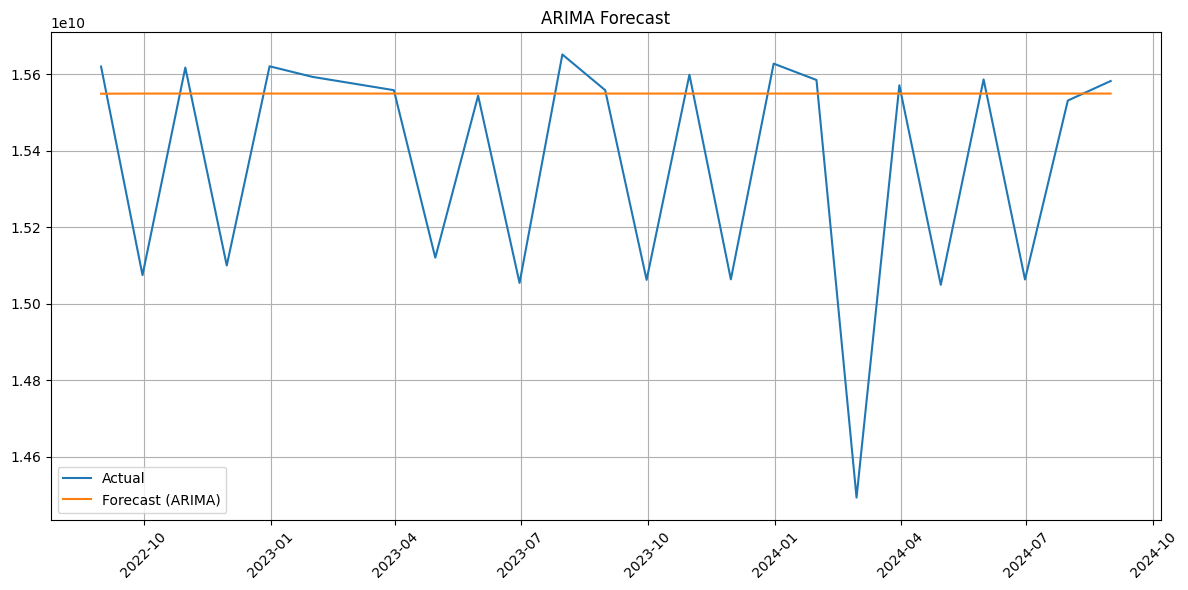

In [32]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Split data into training and testing sets
train_size = int(len(monthly_df) * 0.8)
train, test = monthly_df.iloc[:train_size], monthly_df.iloc[train_size:]

# Fit ARIMA(p,d,q), adjust (p,d,q) as needed
arima_model = ARIMA(train['Total Profit'], order=(1, 1, 1))  # d=1 if not stationary
arima_result = arima_model.fit()

# Forecast
forecast_arima = arima_result.forecast(steps=len(test))
mape_arima = mean_absolute_percentage_error(test['Total Profit'], forecast_arima)
mapa_arima = (1 - mape_arima) * 100
print(f"ARIMA MAPA (Accuracy): {mapa_arima:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
#plt.plot(train.index, train['Total Profit'], label='Train')
plt.plot(test.index, test['Total Profit'], label='Actual')
plt.plot(test.index, forecast_arima, label='Forecast (ARIMA)')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA MAPA (Accuracy): 97.68%


C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Sailesh\.conda\envs\TimeSeriesResearch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


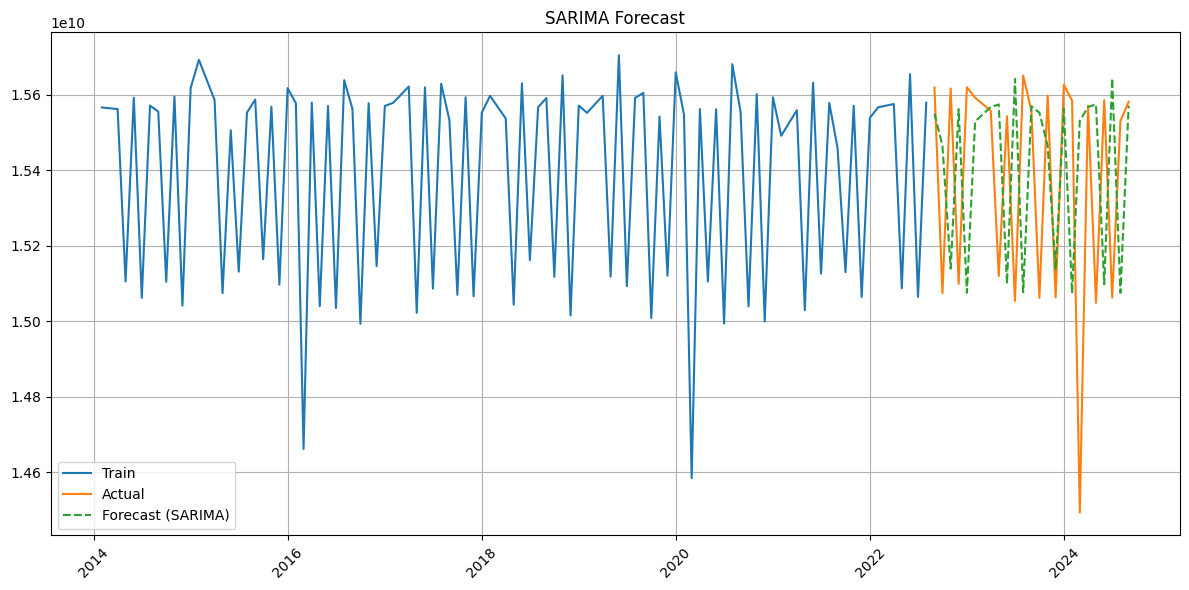

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA(p,d,q)(P,D,Q,s) – Seasonal component
# Assume monthly seasonality (s = 12)

sarima_model = SARIMAX(train['Total Profit'],
                       order=(1, 0, 2),
                       seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Forecast
forecast_sarima = sarima_result.forecast(steps=len(test))
mape_sarima = mean_absolute_percentage_error(test['Total Profit'], forecast_sarima)
mapa_sarima = (1 - mape_sarima) * 100
print(f"SARIMA MAPA (Accuracy): {mapa_sarima:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Total Profit'], label='Train')
plt.plot(test.index, test['Total Profit'], label='Actual')
plt.plot(test.index, forecast_sarima, label='Forecast (SARIMA)', linestyle='--')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
